In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

# Задача

В данном задании вам предлагается решить задачу извлечения аргументов (объектов, аспектов и предикатов) из предложения. Такая модель должна быть обучена на предложениях, где слова или фразы имеют разметку последовательности – каждому слову соответствует его тег.

> **Пример.** Postgres is easier to install and maintain than Oracle.
>
> [Postgres **OBJECT**] is [easier **PREDICATE**] to [install **ASPECT**] and [maintain **ASPECT**] than [Oracle **OBJECT**].

> Сущности могут состоять из нескольких слов: Advil works better for body aches and pains than Motrin.
>
> [Advil **OBJECT**] works [better **PREDICATE**] for [body aches **ASPECT**] and [pains **ASPECT**] than [Motrin **OBJECT**].

Данные состоят из сравнительных предложений (т.е. предложений, содержащих сравнение двух или более объектов). В предложениях содержится следующая информация:

-	*Объекты* – объекты, которые сравниваются
-	*Аспекты* – характеристики, по которым сравниваются объекты
-	*Сказуемое* – слова или фразы, которые реализуют сравнение (обычно сравнительные прилагательные или наречия)

В наборе данных используется схема BIO:

- Первое слово сущности помечается тегом `B-<entity-type>` (начало сущности).
- Второе и последующие слова сущности помечаются тегом `I-<entity-type>` (внутри сущности).
- Слова, которые не являются частью сущности, помечаются тегом `O` (вне сущности).

Поэтому в нашем наборе данных используются следующие метки:
- O
- B-Object
- I-Object
- B-Aspect
- I-Aspect
- B-Predicate
- I-Predicate

**Ваша задача** – присвоить одну из таких меток каждому токену данных путем обучения модели на основе LSTM.


# Data loading

In [2]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)#.to(device)

In [3]:
def read_dataset(filename, splitter="\t"):
    data = []
    sentence = []
    tags = []
    with open(filename) as f:
        for line in f:
            if not line.isspace():
                word, tag = line.split(splitter)
                sentence.append(word)
                tags.append(tag.strip())
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
    return data

In [4]:
# !gdown 1wkfEJCUKF5nbZ6lV6HlRtcEaNkLrLo7y

In [5]:
# !gdown 10kS7glt0sLoh6UIn0RtpREW-zcU_zIay

In [6]:
training_data = read_dataset("./data/train.tsv")

In [7]:
training_data[0]

(['also',
  ',',
  'i',
  'have',
  'recently',
  'discovered',
  'advil',
  'liquigels',
  'work',
  'much',
  'better',
  'and',
  'faster',
  'for',
  'a',
  'headache',
  'than',
  'regular',
  'ibuprofen',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Predicate',
  'O',
  'O',
  'B-Aspect',
  'O',
  'O',
  'B-Object',
  'O'])

In [8]:
test_data = read_dataset("./data/test_no_answer.tsv", splitter="\n")

In [9]:
test_data[0]

(['meanwhile',
  ',',
  'though',
  'windows',
  '8',
  'is',
  'significantly',
  'at',
  'greater',
  'risk',
  '(',
  '1',
  '.',
  '73',
  'percent',
  ')',
  'compared',
  'to',
  'windows',
  '8',
  '.',
  '1',
  ',',
  'according',
  'to',
  'redmond',
  "'",
  's',
  'report',
  ',',
  'it',
  "'",
  's',
  'still',
  'significantly',
  'safer',
  'than',
  'windows',
  '7',
  ',',
  'windows',
  'xp',
  ',',
  'or',
  'windows',
  'vista',
  '.'],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''])

In [10]:
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

for sent, tags in test_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index


tag_to_ix = {
    "O": 0,
    "B-Object": 1,
    "I-Object": 2,
    "B-Aspect": 3,
    "I-Aspect": 4,
    "B-Predicate": 5,
    "I-Predicate": 6
}  # Assign each tag with a unique index

idx_to_tag = dict(map(reversed, tag_to_ix.items()))

EMBEDDING_DIM = 32
HIDDEN_DIM = 64

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Используемое устройство: {device}")

Используемое устройство: mps


# Tagger

Опишите архитектуру нейросети. Все необходимые слои описаны в комментариях. В качестве выхода из модели используйте логистический softmax:

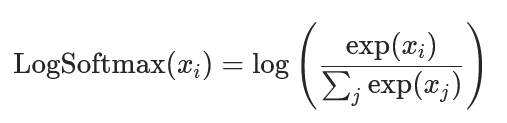

In [12]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        torch.manual_seed(5)
        torch.cuda.manual_seed(5)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.hidden_dim = hidden_dim
        # The Embedding layer with size of the dictionary vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # YOUR CODE HERE

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # YOUR CODE HERE

        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(hidden_dim, tagset_size)
        # YOUR CODE HERE

    def forward(self, sentence):
        # YOUR CODE HERE
        embeddings = self.embedding(sentence)
        out, h = self.lstm(embeddings)
        out = self.linear(out)
        probs = F.log_softmax(out, dim=1)
        
        # return tag scores as a softmax followed by a logarithm
        return probs

# Training

Обучите модель с представленными ниже параметрами.

In [13]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
#model = model.to(device)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [14]:
for epoch in tqdm(range(300)):  # normally you would NOT do 300 epochs, it is toy data
    # YOUR CODE HERE
    for sentence, tags in training_data:
        optimizer.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)#.to(device)
        targets = prepare_sequence(tags, tag_to_ix)#.to(device)
        tag_scores = model(sentence_in.unsqueeze(0))
        loss = loss_function(tag_scores.view(-1, len(tag_to_ix)), targets)
        loss.backward()
        optimizer.step()

100%|██████████| 300/300 [28:31<00:00,  5.71s/it]


# Inference
Предскажите метки для слов из первого предложения.

In [15]:
with torch.no_grad():
    # YOUR CODE HERE
    for sent in tqdm(test_data):
        inputs = prepare_sequence(sent[0], word_to_ix)
        tag_scores = model(inputs)
        tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
        

100%|██████████| 283/283 [00:00<00:00, 1500.69it/s]


Предскажите метки для слов из первого предложения.

In [25]:
with torch.no_grad():
    # Получаем 1-е предложение из тестового набора
    sentence = test_data[0][0]

    # Преобразуем слова в индексы
    inputs = prepare_sequence(sentence, word_to_ix)

    # Прогоняем через модель
    tag_scores = model(inputs)

    # Получаем предсказанные метки
    predicted_tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=1)]

    # Выводим пары (слово, предсказанный_тег)
    print("Предсказанные метки для 1-го предложения:")
    print(result:=list(zip(sentence, predicted_tags)))

Предсказанные метки для 1-го предложения:
[('meanwhile', 'I-Aspect'), (',', 'O'), ('though', 'I-Aspect'), ('windows', 'I-Predicate'), ('8', 'I-Aspect'), ('is', 'B-Predicate'), ('significantly', 'B-Predicate'), ('at', 'I-Aspect'), ('greater', 'B-Predicate'), ('risk', 'B-Aspect'), ('(', 'I-Predicate'), ('1', 'B-Aspect'), ('.', 'O'), ('73', 'I-Aspect'), ('percent', 'I-Aspect'), (')', 'I-Predicate'), ('compared', 'I-Aspect'), ('to', 'I-Aspect'), ('windows', 'B-Predicate'), ('8', 'I-Aspect'), ('.', 'O'), ('1', 'O'), (',', 'O'), ('according', 'B-Predicate'), ('to', 'O'), ('redmond', 'B-Aspect'), ("'", 'I-Predicate'), ('s', 'I-Object'), ('report', 'B-Aspect'), (',', 'O'), ('it', 'B-Predicate'), ("'", 'I-Predicate'), ('s', 'I-Object'), ('still', 'O'), ('significantly', 'B-Aspect'), ('safer', 'B-Predicate'), ('than', 'O'), ('windows', 'B-Object'), ('7', 'B-Predicate'), (',', 'O'), ('windows', 'B-Predicate'), ('xp', 'I-Object'), (',', 'I-Object'), ('or', 'O'), ('windows', 'I-Object'), ('vista', 

In [26]:
for i in result:
    for j in i:
        if j == "greater":
            print(i)

('greater', 'B-Predicate')


Предскажите метки для слов из 11 предложения.

In [27]:
with torch.no_grad():
    # Получаем 11-е предложение из тестового набора
    sentence = test_data[10][0]

    # Преобразуем слова в индексы
    inputs = prepare_sequence(sentence, word_to_ix)

    # Прогоняем через модель
    tag_scores = model(inputs)

    # Получаем предсказанные метки
    predicted_tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=1)]

    # Выводим пары (слово, предсказанный_тег)
    print("Предсказанные метки для 11-го предложения:")
    print(result:=list(zip(sentence, predicted_tags)))

Предсказанные метки для 11-го предложения:
[('but', 'O'), ('that', 'O'), ('aside', 'I-Object'), (',', 'O'), ('windows', 'B-Predicate'), ('10', 'B-Predicate'), ('is', 'O'), ('still', 'O'), ('easier', 'B-Predicate'), ('to', 'I-Predicate'), ('navigate', 'B-Aspect'), ('than', 'I-Predicate'), ('mac', 'I-Aspect'), ('os', 'I-Aspect'), ('x', 'I-Aspect'), ('and', 'I-Aspect'), ('windows', 'B-Predicate'), ('8', 'I-Predicate'), (',', 'I-Predicate'), ('has', 'B-Predicate'), ('better', 'B-Predicate'), ('access', 'B-Aspect'), ('to', 'I-Aspect'), ('files', 'I-Aspect'), ('than', 'I-Aspect'), ('in', 'B-Predicate'), ('android', 'B-Object'), (',', 'I-Object'), ('and', 'I-Object'), ('is', 'O'), ('faster', 'B-Predicate'), (',', 'I-Predicate'), ('more', 'B-Predicate'), ('flexible', 'I-Predicate'), ('and', 'I-Predicate'), ('more', 'B-Predicate'), ('capable', 'I-Predicate'), ('than', 'I-Predicate'), ('windows', 'B-Object'), ('xp', 'I-Object'), ('and', 'I-Object'), ('the', 'O'), ('home', 'I-Object'), ('and', 'I

In [28]:
for i in result:
    for j in i:
        if j == "flexible":
            print(i)

('flexible', 'I-Predicate')


In [29]:
with torch.no_grad():
    # Получаем 101-е предложение (индекс 100)
    sentence = test_data[100][0]

    # Преобразуем слова в индексы
    inputs = prepare_sequence(sentence, word_to_ix)

    # Прогоняем через модель
    tag_scores = model(inputs)

    # Получаем предсказанные метки
    predicted_tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=1)]

    # Выводим пары (слово, предсказанный_тег)
    print("Предсказанные метки для 101-го предложения:")
    tagged_sentence = list(zip(sentence, predicted_tags))
    print(tagged_sentence)

Предсказанные метки для 101-го предложения:
[('fyi', 'I-Predicate'), ('-', 'I-Predicate'), ('i', 'B-Predicate'), ('like', 'B-Predicate'), ('my', 'B-Predicate'), ('ipad', 'B-Aspect'), ('but', 'O'), ('usually', 'B-Predicate'), ('only', 'I-Aspect'), ('use', 'B-Predicate'), ('it', 'I-Predicate'), ('when', 'I-Predicate'), ('i', 'B-Predicate'), ("'", 'I-Predicate'), ('m', 'O'), ('traveling', 'B-Aspect'), ('since', 'B-Predicate'), ('its', 'O'), ('so', 'O'), ('much', 'B-Predicate'), ('lighter', 'B-Predicate'), ('to', 'B-Predicate'), ('carry', 'B-Aspect'), ('around', 'I-Aspect'), ('than', 'O'), ('a', 'O'), ('laptop', 'O'), ('and', 'O'), ('way', 'O'), ('easier', 'B-Predicate'), ('to', 'I-Predicate'), ('read', 'B-Aspect'), ('than', 'I-Predicate'), ('my', 'B-Predicate'), ('phone', 'I-Object'), ('.', 'I-Object')]


In [30]:
# Считаем количество слов с меткой "O"
count_O = sum(1 for word, tag in tagged_sentence if tag == "O")

print(f"Количество слов с меткой 'O': {count_O}")

Количество слов с меткой 'O': 9


Сохраните результаты предсказания на тестовом наборе (`test_data`) в файл, запустив код ниже.

In [31]:
with open("./data/out_test.tsv", "w") as w:
    with torch.no_grad():
        for sentence in tqdm(test_data):
            inputs = prepare_sequence(sentence[0], word_to_ix)
            tag_scores = model(inputs)
            tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
            for i, y in zip(sentence[0], tags):
                w.write(f"{i}\t{y}\n")
            w.write("\n")

100%|██████████| 283/283 [00:00<00:00, 2231.11it/s]


Файл `test.tsv` содержит разметку тестовых данных. Сравните файлы построчно, запустив код ниже. Сколько суммарно меток было предсказано верно (то есть сколько строк совпало)?

In [23]:
# !gdown 1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd

In [32]:
points = 0
with open("./data/test.tsv", "r") as f_eval, open("./data/out_test.tsv", "r") as f:
  for line_eval, line in zip(f_eval.readlines(), f.readlines()):
    if line_eval == line: points += 1
print(points)

2890
